<font size="6">Import necessary libraries</font>

In [1]:
# Import necessary libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the dataset from CSV file
data = pd.read_csv('marathi.csv')  # Replace with the actual file path


#Define a custom set of Gujarati stopwords

In [4]:
# Define a custom set of Gujarati stopwords
marathi_stopwords = set(["आहे", "आहेस", "आहेत", "होते", "होतेस", "होतेत", "झालं", "झाली", "झाले", "हे", "तो", "ती", "ते", "या", "या", "मी", "आम्ही", "तू", "तुम्ही", "आम्हाला", "तुला", "तुम्हाला", "माझं", "तुझं", "तिचं", "त्याचं", "त्यांचं", "त्यांचा", "तिचा", "तिचं", "त्यात", "त्यावर", "त्याच्या", "यांच्या", "हा", "ह्या", "त्या", "मी", "आम्हाला", "आहे", "होते", "नाही", "कधी", "कुठे", "का", "जेव्हा", "जे", "कोण", "कसा", "कसे", "किती", "इथे", "तिथे", "आता", "पुन्हा", "म्हणून", "किंवा", "पण", "मात्र", "म्हणूनच", "जर", "तर", "आणि", "बरोबर", "नाहीतर", "शक्यतो", "सगळे", "संपूर्ण", "काही", "कोणता", "कोणती", "कोणते", "काय", "कुठला", "कुठेही", "कुणीही", "काहीच", "काहीही", "सर्व", "तसेच", "म्हणूनच", "आता", "पुढे", "मागे", "नेहमी", "थोडा", "खूप", "मोठा", "छोटा", "साधारण", "पूर्ण", "नंतर"
])

# Define a function to clean and preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Marathi (Devanagari) characters
    text = ' '.join([word for word in text.split() if word not in marathi_stopwords])  # Remove stopwords
    return text

# Apply preprocessing to the 'Sentence' column
data['cleaned_sentence'] = data['Sentence'].apply(preprocess_text)

# Filter out short sentences (less than 5 words)
data = data[data['cleaned_sentence'].apply(lambda x: len(x.split()) >= 5)]


#Encode the target labels for Sentiment and Emotion

In [5]:
# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

# Fit the encoders and transform the labels into numeric values
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])


#Encode the target labels for Sentiment and Emotion

In [6]:
# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

# Fit the encoders and transform the labels into numeric values
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])


#Tokenize the text data and pad sequences for uniform length

In [7]:
# Assuming you have already preprocessed the 'cleaned_sentence' column
# and encoded the sentiment/emotion labels

# Split data into training and test sets for both sentiment and emotion
X_train, X_test, y_sentiment_train, y_sentiment_test, y_emotion_train, y_emotion_test = train_test_split(
    data['cleaned_sentence'], data['encoded_sentiment'], data['encoded_emotion'], test_size=0.2, random_state=42
)

# Tokenize the text data and pad sequences for uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them the same length
max_seq_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [8]:


# # Tokenize the text data and pad sequences for uniform length
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)

# # Convert text to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# # Pad the sequences to make them the same length
# max_seq_len = max([len(seq) for seq in X_train_seq])
# X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
# X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# # Get vocabulary size
# vocab_size = len(tokenizer.word_index) + 1


#Define Bidirectional GRU Model

In [9]:
# Define the Bidirectional GRU model
embedding_dim = 128
gru_units = 64

# Input layer
input_layer = Input(shape=(max_seq_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input_layer)

# Bidirectional GRU layer
gru_layer = Bidirectional(GRU(gru_units, return_sequences=False))(embedding_layer)

# Dropout for regularization
dropout_layer = Dropout(0.5)(gru_layer)

# Shared Dense layer
shared_dense_layer = Dense(64, activation='relu')(dropout_layer)

# Sentiment output
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(shared_dense_layer)

# Emotion output
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(shared_dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[sentiment_output, emotion_output])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#Compile and Summarize Model

In [10]:
# Compile the model with loss functions and metrics for both outputs
model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy',
                    'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'})

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 23)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 23, 128)        │      1,250,304 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         74,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 9)              │            585 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,333,836 (5.09 MB)

 Trainable params: 1,333,836 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

#Train the Model

In [11]:
# Train the model on the training data
history = model.fit(
    X_train_pad,
    {'sentiment_output': y_sentiment_train, 'emotion_output': y_emotion_train},
    epochs=10,  # Adjust number of epochs if needed
    batch_size=128,
    validation_data=(X_test_pad, {'sentiment_output': y_sentiment_test, 'emotion_output': y_emotion_test})
)


Epoch 1/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - emotion_output_accuracy: 0.6562 - loss: 1.1448 - sentiment_output_accuracy: 0.8583 - val_emotion_output_accuracy: 0.9153 - val_loss: 0.1642 - val_sentiment_output_accuracy: 0.9959
Epoch 2/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - emotion_output_accuracy: 0.9214 - loss: 0.1516 - sentiment_output_accuracy: 0.9976 - val_emotion_output_accuracy: 0.9196 - val_loss: 0.1429 - val_sentiment_output_accuracy: 0.9971
Epoch 3/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - emotion_output_accuracy: 0.9294 - loss: 0.1245 - sentiment_output_accuracy: 0.9986 - val_emotion_output_accuracy: 0.9212 - val_loss: 0.1411 - val_sentiment_output_accuracy: 0.9957
Epoch 4/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - emotion_output_accuracy: 0.9323 - loss: 0.1139 - sentiment_output_accuracy: 0.9989 - val_emotion_output_accuracy: 0.9209 - val_loss: 0.1292 - val_sentiment_output_accuracy: 0.9982
Epoch 5/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 20s 10

In [12]:
# Save the trained model to an HDF5 file
model.save('sentiment_emotion_gru_model.h5')


# Predict sentiment and emotion on test data

In [13]:
# Predict sentiment and emotion on test data
y_sentiment_pred, y_emotion_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_sentiment_pred = np.argmax(y_sentiment_pred, axis=1)
y_emotion_pred = np.argmax(y_emotion_pred, axis=1)

# Sentiment evaluation metrics
sentiment_accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred)
sentiment_precision = precision_score(y_sentiment_test, y_sentiment_pred, average='weighted')
sentiment_recall = recall_score(y_sentiment_test, y_sentiment_pred, average='weighted')
sentiment_f1 = f1_score(y_sentiment_test, y_sentiment_pred, average='weighted')
sentiment_conf_matrix = confusion_matrix(y_sentiment_test, y_sentiment_pred)

# Emotion evaluation metrics
emotion_accuracy = accuracy_score(y_emotion_test, y_emotion_pred)
emotion_precision = precision_score(y_emotion_test, y_emotion_pred, average='weighted')
emotion_recall = recall_score(y_emotion_test, y_emotion_pred, average='weighted')
emotion_f1 = f1_score(y_emotion_test, y_emotion_pred, average='weighted')
emotion_conf_matrix = confusion_matrix(y_emotion_test, y_emotion_pred)

# Print sentiment results
print(f"Sentiment - Accuracy: {sentiment_accuracy}")
print(f"Sentiment - Precision: {sentiment_precision}")
print(f"Sentiment - Recall: {sentiment_recall}")
print(f"Sentiment - F1 Score: {sentiment_f1}")
print("Sentiment - Confusion Matrix:")
print(sentiment_conf_matrix)

# Print emotion results
print(f"Emotion - Accuracy: {emotion_accuracy}")
print(f"Emotion - Precision: {emotion_precision}")
print(f"Emotion - Recall: {emotion_recall}")
print(f"Emotion - F1 Score: {emotion_f1}")
print("Emotion - Confusion Matrix:")
print(emotion_conf_matrix)


1108/1108 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Sentiment - Accuracy: 0.9983628768205939
Sentiment - Precision: 0.9983627882233703
Sentiment - Recall: 0.9983628768205939
Sentiment - F1 Score: 0.9983626771687519
Sentiment - Confusion Matrix:
[[12227     0     0]
 [    3 11909    21]
 [    3    31 11234]]
Emotion - Accuracy: 0.9236479620639042
Emotion - Precision: 0.9239458677772145
Emotion - Recall: 0.9236479620639042
Emotion - F1 Score: 0.9236379556036023
Emotion - Confusion Matrix:
[[3968    0    1    0    1    0    3    2    1]
 [   0 4219    0    1    0    0    0    0    4]
 [   6    0 3623    0   13    0    0    5    1]
 [   0    0    0 2596    0    0    0    0 1433]
 [   1    0   12    2 3932    5    2    3    0]
 [   4    0    3    0    3 3578    1    0    0]
 [   4    0    0    2    1    1 3714    0    0]
 [   2    2    6    0    3    1    1 4294    0]
 [   0    0    0 1175    0    0    0    0 2799]]


#ROC and AUC curve

1108/1108 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


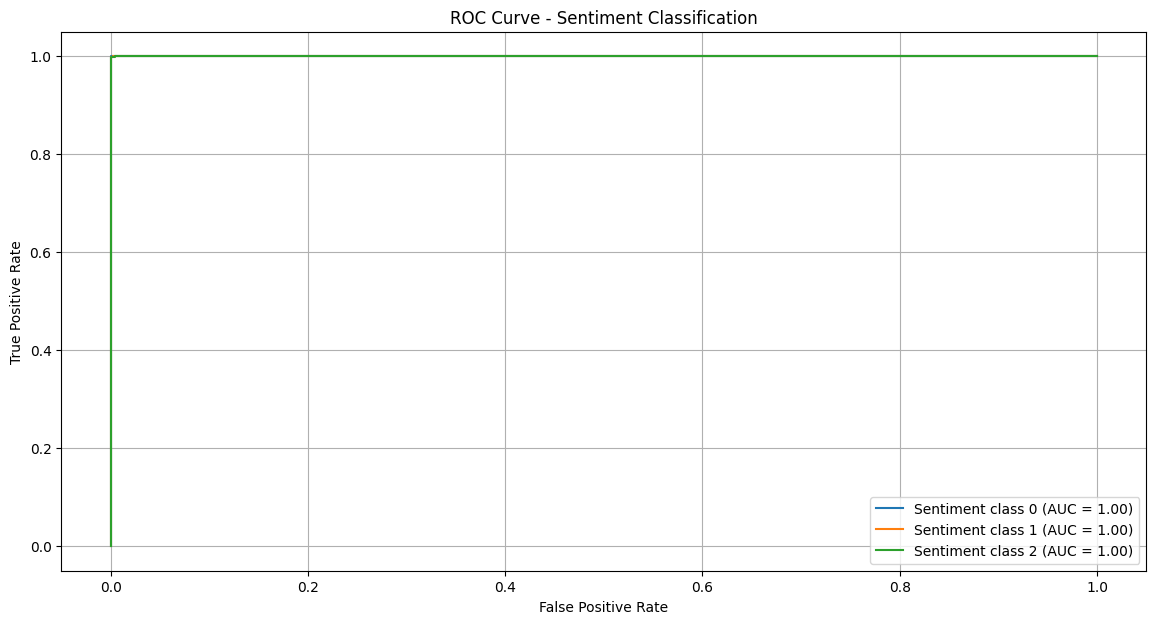

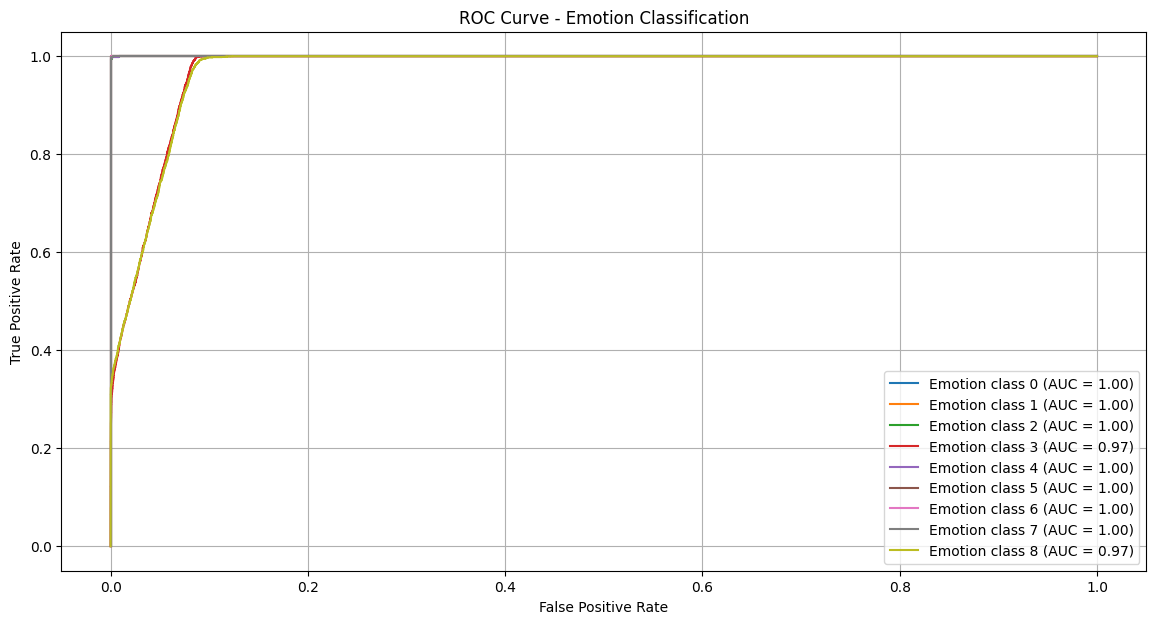

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the sentiment and emotion labels for AUC calculation
y_sentiment_test_binarized = label_binarize(y_sentiment_test, classes=range(len(sentiment_encoder.classes_)))
y_emotion_test_binarized = label_binarize(y_emotion_test, classes=range(len(emotion_encoder.classes_)))

# Get the predicted probabilities
y_sentiment_pred_prob, y_emotion_pred_prob = model.predict(X_test_pad)

# Plotting ROC curve for each sentiment class
plt.figure(figsize=(14, 7))

# Sentiment ROC curves
for i in range(len(sentiment_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_sentiment_test_binarized[:, i], y_sentiment_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sentiment class {i} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Sentiment Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Emotion ROC curves
plt.figure(figsize=(14, 7))
for i in range(len(emotion_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_emotion_test_binarized[:, i], y_emotion_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Emotion class {i} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Emotion Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#Bar Plot for Random Sample Sentences (Sentiment & Emotion Comparison)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


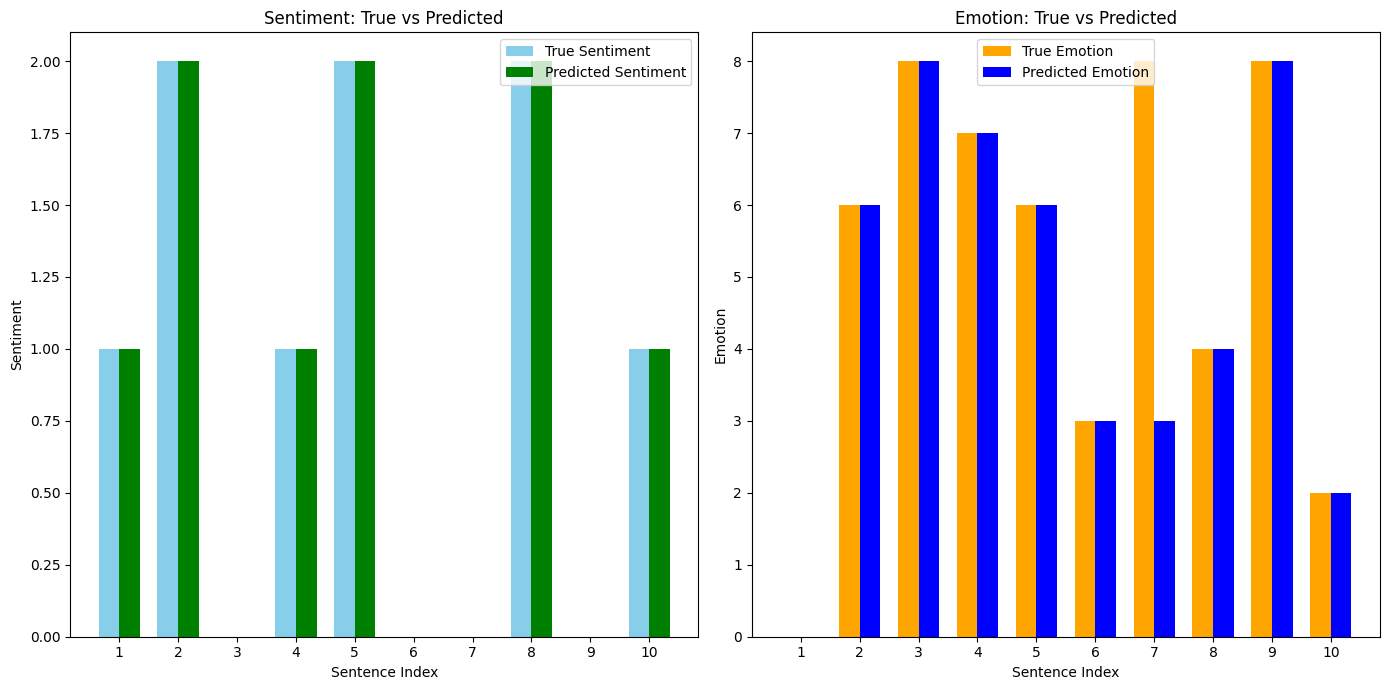

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 10 sentences from the dataset for testing
sample_data = data.sample(n=10, random_state=42)
sample_sentences = sample_data['Sentence'].tolist()
sample_true_sentiments = sample_data['encoded_sentiment'].tolist()
sample_true_emotions = sample_data['encoded_emotion'].tolist()

# Tokenize and pad the random sample sentences
sample_sequences = tokenizer.texts_to_sequences(sample_sentences)
sample_padded_sequences = pad_sequences(sample_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
sample_sentiment_pred, sample_emotion_pred = model.predict(sample_padded_sequences)

# Convert predictions to class labels
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Set up the figure
plt.figure(figsize=(14, 7))

# Sentiment Comparison
plt.subplot(1, 2, 1)
x = np.arange(len(sample_sentences))  # Label locations
bar_width = 0.35  # Width of the bars

# Plot bars for true sentiment
plt.bar(x - bar_width/2, sample_true_sentiments, width=bar_width, color='skyblue', label='True Sentiment')

# Plot bars for predicted sentiment
plt.bar(x + bar_width/2, sample_sentiment_pred_labels, width=bar_width, color='green', label='Predicted Sentiment')

# Label the plot
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Comparison
plt.subplot(1, 2, 2)

# Plot bars for true emotion
plt.bar(x - bar_width/2, sample_true_emotions, width=bar_width, color='orange', label='True Emotion')

# Plot bars for predicted emotion
plt.bar(x + bar_width/2, sample_emotion_pred_labels, width=bar_width, color='blue', label='Predicted Emotion')

# Label the plot
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sentence Index')
plt.ylabel('Emotion')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
# Shuffle the data to mix different sentiments and emotions
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)


#Line Plot for Paragraph Sentiment and Emotion Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


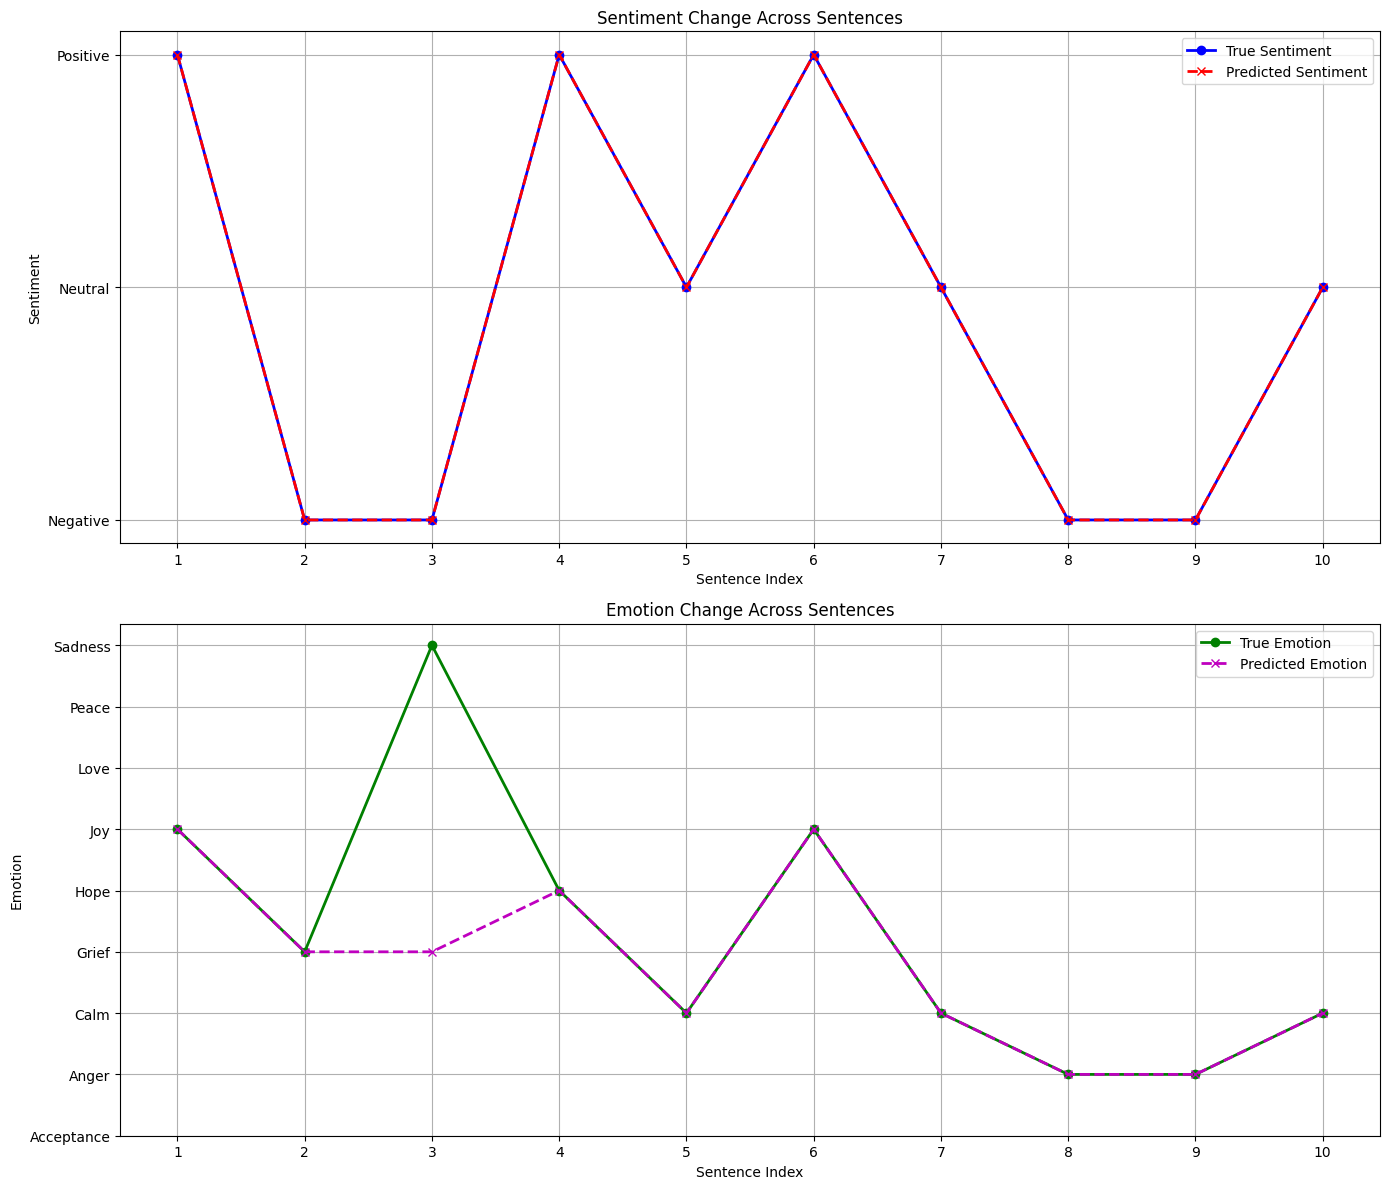

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the number of samples
n_samples = 10  # Total sentences to sample

# Stratified sampling based on sentiment
splitter = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)

for _, test_idx in splitter.split(shuffled_data, shuffled_data['encoded_sentiment']):
    strat_sample = shuffled_data.iloc[test_idx]

# If needed, ensure stratification on emotion as well
# Note: Stratified sampling on multiple labels is more complex and may require custom handling

# Now, use 'strat_sample' for visualization
paragraph_sentences = strat_sample['Sentence'].tolist()
paragraph_true_sentiments = strat_sample['encoded_sentiment'].tolist()
paragraph_true_emotions = strat_sample['encoded_emotion'].tolist()

# Tokenize and pad the sentences
paragraph_sequences = tokenizer.texts_to_sequences(paragraph_sentences)
paragraph_padded_sequences = pad_sequences(paragraph_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion for the paragraph using the trained model
paragraph_sentiment_pred, paragraph_emotion_pred = model.predict(paragraph_padded_sequences)

# Convert predictions to class labels
paragraph_sentiment_pred_labels = np.argmax(paragraph_sentiment_pred, axis=1)
paragraph_emotion_pred_labels = np.argmax(paragraph_emotion_pred, axis=1)

# Get class labels from encoders for plotting
true_sentiment_labels = sentiment_encoder.inverse_transform(paragraph_true_sentiments)
predicted_sentiment_labels = sentiment_encoder.inverse_transform(paragraph_sentiment_pred_labels)

true_emotion_labels = emotion_encoder.inverse_transform(paragraph_true_emotions)
predicted_emotion_labels = emotion_encoder.inverse_transform(paragraph_emotion_pred_labels)

# Map sentiment and emotion labels to indices for plotting
sentiment_index = {label: idx for idx, label in enumerate(sentiment_encoder.classes_)}
emotion_index = {label: idx for idx, label in enumerate(emotion_encoder.classes_)}

# Convert label names to indices for plotting
true_sentiment_indices = [sentiment_index[label] for label in true_sentiment_labels]
predicted_sentiment_indices = [sentiment_index[label] for label in predicted_sentiment_labels]

true_emotion_indices = [emotion_index[label] for label in true_emotion_labels]
predicted_emotion_indices = [emotion_index[label] for label in predicted_emotion_labels]

# Create line plots with enhanced readability
plt.figure(figsize=(14, 12))

# Plot Sentiment
plt.subplot(2, 1, 1)
plt.plot(range(len(paragraph_sentences)), true_sentiment_indices, marker='o', linestyle='-', color='b', label='True Sentiment', linewidth=2)
plt.plot(range(len(paragraph_sentences)), predicted_sentiment_indices, marker='x', linestyle='--', color='r', label='Predicted Sentiment', linewidth=2)
plt.title('Sentiment Change Across Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment')
plt.yticks(ticks=range(len(sentiment_encoder.classes_)), labels=sentiment_encoder.classes_)
plt.xticks(range(len(paragraph_sentences)), range(1, len(paragraph_sentences) + 1))
plt.legend()
plt.grid(True)

# Plot Emotion
plt.subplot(2, 1, 2)
plt.plot(range(len(paragraph_sentences)), true_emotion_indices, marker='o', linestyle='-', color='g', label='True Emotion', linewidth=2)
plt.plot(range(len(paragraph_sentences)), predicted_emotion_indices, marker='x', linestyle='--', color='m', label='Predicted Emotion', linewidth=2)
plt.title('Emotion Change Across Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Emotion')
plt.yticks(ticks=range(len(emotion_encoder.classes_)), labels=emotion_encoder.classes_)
plt.xticks(range(len(paragraph_sentences)), range(1, len(paragraph_sentences) + 1))
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Define 5 custom Gujarati sentences (poem lines) with English translations

In [18]:
# Define 5 custom Gujarati sentences (poem lines) with English translations
custom_sentences =["तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे",
"तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय",
"सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं",
"शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जातं",
"तुझ्या सहवासात प्रत्येक क्षणाचं अनमोल महत्त्व उमजतं, आणि जग सुंदर भासतं"
]


# Tokenize and pad the custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
custom_sentiment_pred, custom_emotion_pred = model.predict(custom_padded_sequences)

# Convert predictions to class labels
custom_sentiment_pred_labels = np.argmax(custom_sentiment_pred, axis=1)
custom_emotion_pred_labels = np.argmax(custom_emotion_pred, axis=1)

# Get the label names from encoders
predicted_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_pred_labels)
predicted_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_pred_labels)

# English translations of the custom sentences
english_translations = ["Your bitter words have only intensified the smoldering fire within me",
"Your departure in this manner makes it feel like each day grows dimmer and dimmer",
"When the truth came forward, it felt like all dreams shattered, yet the journey must continue",
"Sitting quietly and feeling the gentle touch of the wind, the mysteries of the universe slowly unfold",
"Every moment with you feels precious, and the world seems beautiful in your presence"

]





# Display the results with English translations
for i, sentence in enumerate(custom_sentences):
    print(f"Gujarati Sentence: {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {predicted_sentiment_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotion_labels[i]}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gujarati Sentence: तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे
English Translation: Your bitter words have only intensified the smoldering fire within me
Predicted Sentiment: Negative
Predicted Emotion: Anger
--------------------------------------------------
Gujarati Sentence: तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय
English Translation: Your departure in this manner makes it feel like each day grows dimmer and dimmer
Predicted Sentiment: Negative
Predicted Emotion: Sadness
--------------------------------------------------
Gujarati Sentence: सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं
English Translation: When the truth came forward, it felt like all dreams shattered, yet the journey must continue
Predicted Sentiment: Negative
Predicted Emotion: Hope
--------------------------------------------------
Gujarati Sentence: शांततेत बसून वाऱ्याच्या हळुवार स्

Process Overview:
Library Imports:

The first step involves importing various necessary libraries:
Pandas (pd): Used for data manipulation and analysis, mainly dealing with CSV files and DataFrames.
Regular Expressions (re): For text processing and pattern matching.
Scikit-learn (train_test_split, LabelEncoder, accuracy_score, etc.): Used for preprocessing data, splitting datasets, encoding labels, and evaluating model performance.
Numpy (np): Provides support for large, multi-dimensional arrays and matrices, along with mathematical functions.
Matplotlib (plt): For plotting graphs and visualizing results.
TensorFlow & Keras (Model, GRU, etc.): For building deep learning models, specifically using GRU (Gated Recurrent Units) layers for handling sequence data (text data in this case).
Data Loading:

The dataset is loaded from a CSV file using Pandas (pd.read_csv('q12.csv')). This is likely text-based data, as indicated by the subsequent preprocessing steps.
Data Preprocessing:

Tokenization & Padding:
Tokenization: The text data is transformed into sequences of numbers where each number corresponds to a unique word.
Padding: After tokenization, sequences are padded to ensure uniform length, a necessary step for feeding the data into neural networks.
Label Encoding:
Labels or target variables (if categorical) are transformed into numeric values using LabelEncoder. This is essential for machine learning models.
Splitting Data:

The dataset is split into training and testing sets using the train_test_split function from Scikit-learn. This ensures that part of the data is reserved for evaluating model performance after training.
Building the Model:

Input Layer:
Defines the shape of the input, which would typically be the length of the padded sequences.
Embedding Layer:
This layer converts word indices into dense vectors of fixed size, capturing semantic information about the words.
Bidirectional GRU Layer:
A GRU (Gated Recurrent Unit) is used here, a type of recurrent neural network (RNN) well-suited for sequential data like text.
The Bidirectional wrapper ensures that the GRU processes the input sequence in both forward and backward directions, capturing more context.
Dense Layers with Dropout:
Fully connected dense layers are used for classification, followed by dropout layers to prevent overfitting.
Output Layer:
A final layer that provides the model’s prediction, usually followed by an activation function such as Softmax or Sigmoid (depending on the type of classification task).
Model Compilation & Training:

Compilation:
The model is compiled with a loss function (categorical cross-entropy for multi-class classification, or binary cross-entropy for binary classification), an optimizer (such as Adam), and evaluation metrics (accuracy, precision, recall, etc.).
Training:
The model is trained on the training data, with the option to specify the number of epochs (iterations over the dataset) and batch size (number of samples processed before updating model parameters).
Evaluation:

After training, the model is evaluated on the test data using various metrics like accuracy, precision, recall, F1-score, and confusion matrix.
Visualization:

Matplotlib is likely used to plot training history (loss and accuracy over time), confusion matrices, or other performance metrics.
Detailed Table of Key Components:
Step	Description
1. Import Libraries	Importing libraries for data manipulation, machine learning, and deep learning (Pandas, Scikit-learn, Keras, TensorFlow, etc.).
2. Load Dataset	Loading text-based data from a CSV file into a Pandas DataFrame for further processing.
3. Preprocessing	Tokenizing and padding text sequences, encoding labels, and splitting data into training and testing sets.
4. Model Building	Defining a neural network model with an embedding layer, Bidirectional GRU layer, Dense layers, and Dropout layers.
5. Model Compilation	Compiling the model with a suitable loss function, optimizer, and evaluation metrics.
6. Training	Training the model on the preprocessed data for a specified number of epochs and batch size.
7. Evaluation	Evaluating model performance using metrics like accuracy, precision, recall, F1-score, and confusion matrix.
8. Visualization	Using Matplotlib to plot training history and performance metrics.